# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier

# Directories

In [2]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/XGBoost"

netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [81]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [82]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [83]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [84]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [85]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [4]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv")

In [5]:
data.shape

(235449, 110)

# Features

In [6]:
def get_features(netconfig_path):
    
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

In [7]:
features_all = []

for one_particle in particles:
    
    netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
    + one_particle + "_Long_ANN.txt"

    features_all += get_features(netconfig_path)

In [8]:
features = numpy.unique(features_all)
features

array(['BremPIDe', 'CaloPrsE', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe',
       'HcalPIDmu', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon',
       'InAccPrs', 'MuonBkgLL', 'MuonIsLooseMuon', 'MuonIsMuon',
       'MuonMuLL', 'MuonNShared', 'PrsPIDe', 'RichAboveKaThres',
       'RichAboveMuThres', 'RichAbovePiThres', 'RichAbovePrThres',
       'RichDLLbt', 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp',
       'RichUsedR1Gas', 'RichUsedR2Gas', 'TrackChi2PerDof',
       'TrackFitMatchChi2', 'TrackFitTChi2', 'TrackFitTNDoF',
       'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackGhostProbability',
       'TrackNumDof', 'TrackP', 'TrackPt'], 
      dtype='|S21')

# Train XGBoost

In [9]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [10]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.01 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.0470898 ,  0.07890646,  0.41969519])

In [11]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [12]:
%%time
clf = XGBoostClassifier(n_estimators=1000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=4, 
                        subsample=0.5, 
                        max_depth=8,
                        min_child_weight = 50,
                        features=features)

clf.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)

CPU times: user 2h 28min 17s, sys: 6.73 s, total: 2h 28min 24s
Wall time: 38min 19s


# Save the classifier

In [13]:
params = clf.get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [14]:
new_work_path = work_path + "/" + params_str + 'balanced_data_' + str(len(data))
new_work_path

'baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;gamma=None;nthreads=4;balanced_data_235449'

In [15]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
pickle.dump(clf, clf_pickle)
clf_pickle.close()

In [46]:
# new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/\
# multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;\
# base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=100;colsample=0.7;max_depth=8;\
# gamma=None;nthreads=4;"

In [48]:
# Read classifier
# clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
# clf = pickle.load(clf_pickle2)
# clf_pickle2.close()

# Test the classifier

In [16]:
probas = clf.predict_proba(data.loc[test_inds])

In [17]:
probas[:5, :]

array([[  4.62493785e-02,   9.23532248e-03,   5.32213449e-02,
          4.12242532e-01,   2.00672314e-01,   2.78379083e-01],
       [  6.57152012e-03,   1.53007433e-02,   2.80926321e-02,
          4.89158221e-02,   3.79388571e-01,   5.21730721e-01],
       [  2.20126197e-01,   6.81018382e-02,   1.16915023e-02,
          6.89650178e-02,   3.29422385e-01,   3.01693052e-01],
       [  5.96558392e-01,   3.94641399e-01,   1.29669532e-03,
          2.99562165e-03,   2.11925013e-03,   2.38865474e-03],
       [  3.50153400e-03,   3.29533534e-04,   4.06518142e-04,
          9.94115353e-01,   7.92873790e-04,   8.54128913e-04]], dtype=float32)

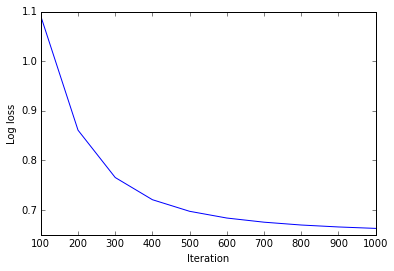

In [18]:
step = clf.get_params()['n_estimators'] / 10
staged_probas = clf.staged_predict_proba(data.loc[test_inds], step=step)

from sklearn.metrics import log_loss
log_loss_all = []
for pred in staged_probas:
    log_loss_all.append(log_loss(labels_test, pred))

x = numpy.arange(step, clf.get_params()['n_estimators'] + step, step)
plt.plot(x, log_loss_all)
plt.ylabel('Log loss')
plt.xlabel('Iteration')
plt.show()

### Logloss

In [19]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

0.6629206893577041

### Roc curves

In [20]:
import os, sys
sys.path.append('../python')
import utils

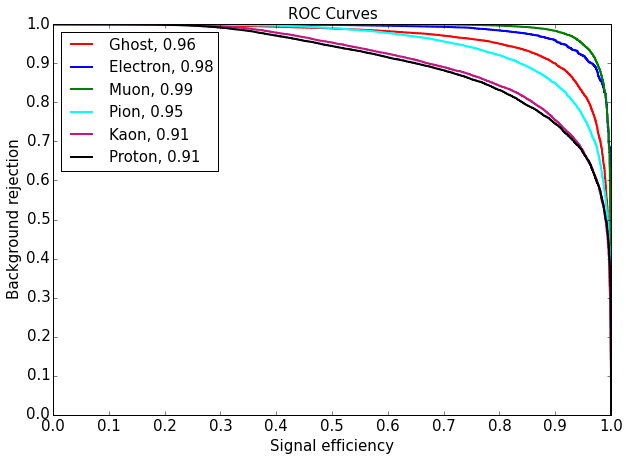

In [21]:
utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

# Evaluation

In [22]:
import os, sys
sys.path.append('../python')
import utils

In [23]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [24]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [67]:
proba_eval = clf.predict_proba(data_eval)

In [68]:
#numpy.savetxt(new_work_path + '/xgboost_proba_eval.csv', proba_eval)

In [69]:
#proba_eval = numpy.loadtxt(new_work_path + '/xgboost_proba_eval.csv')

In [70]:
proba_eval[:5, :]

array([[  2.64883996e-03,   5.28744655e-03,   6.35735877e-03,
          4.48650355e-03,   1.14522994e-01,   8.66696835e-01],
       [  2.54088361e-03,   1.20080658e-03,   8.69142008e-04,
          1.34909793e-03,   7.33161449e-01,   2.60878682e-01],
       [  1.13617890e-02,   1.65307440e-03,   7.37683615e-03,
          9.56071734e-01,   1.10285655e-02,   1.25079537e-02],
       [  2.07290605e-01,   1.11329682e-01,   6.80867024e-03,
          4.56784785e-01,   5.36741875e-02,   1.64112106e-01],
       [  1.59159228e-02,   1.12905086e-03,   7.55424669e-04,
          9.79843080e-01,   1.19352690e-03,   1.16303924e-03]], dtype=float32)

### Get all figures from baseline

In [71]:
from get_figures import all_figures

In [72]:
# for num in range(0, len(particles)):
        
#     one_particle = particles[num]
#     one_lab = labs[num]

#     one_labels = (labels_eval == one_lab)*1
#     one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
#     params = {}
#     params['PARTICLE'] = one_particle
#     params['TRACK'] = 'Long'
    
#     all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")

### Logloss

In [73]:
from sklearn.metrics import log_loss

log_loss(labels_eval, proba_eval)

0.6793676435510938

### Roc curves, roc auc matrix and roc auc ratio matrix

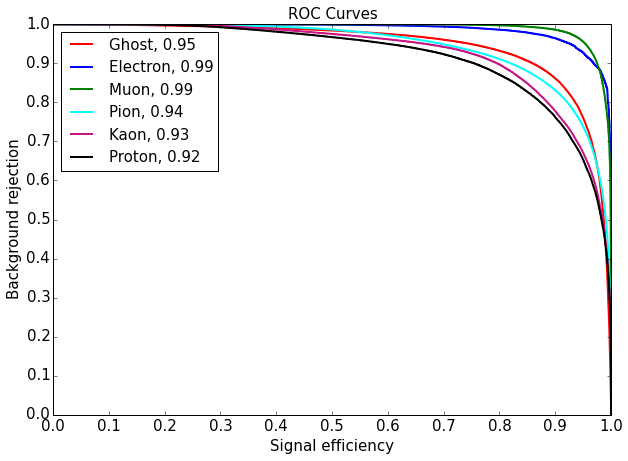

In [74]:
utils.get_roc_curves(labels_eval, proba_eval, particles, save_path=None, show=True)

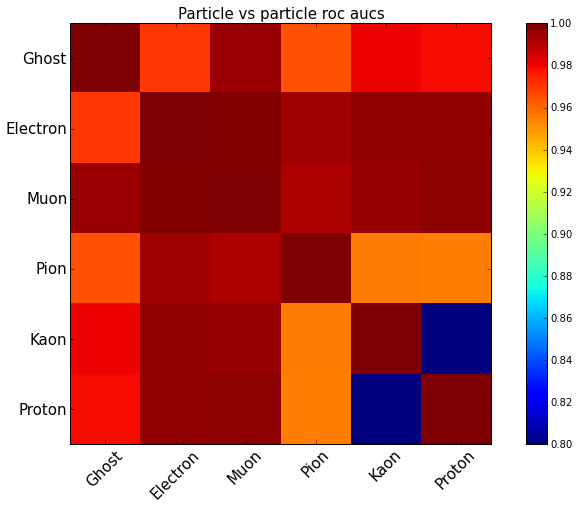

,Class,Ghost,Electron,Muon,Pion,Kaon,Proton
0,Ghost,1.000000,0.969712,0.995253,0.964764,0.980980,0.979101
1,Electron,0.969712,1.000000,0.999076,0.994367,0.996463,0.996488
2,Muon,0.995253,0.999076,1.000000,0.992033,0.996057,0.996906
3,Pion,0.964764,0.994367,0.992033,1.000000,0.955744,0.955101
4,Kaon,0.980980,0.996463,0.996057,0.955744,1.000000,0.781684
5,Proton,0.979101,0.996488,0.996906,0.955101,0.781684,1.000000


In [75]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_eval, proba_eval, particles, save_path=None, show=True)
roc_auc_matrix

In [76]:
roc_auc_matrix_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv")

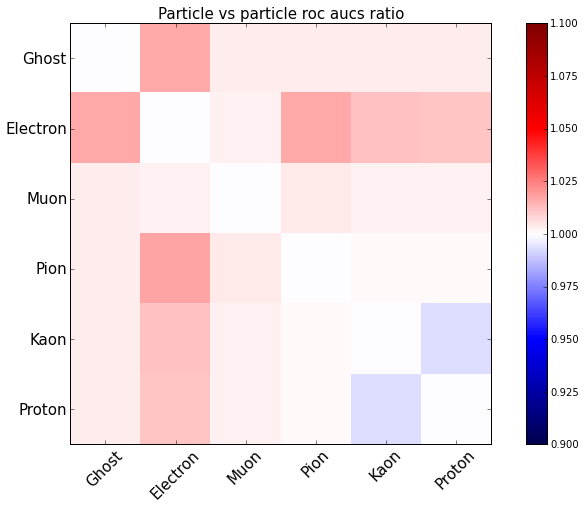

,Class,Ghost,Electron,Muon,Pion,Kaon,Proton
0,Ghost,1.000000,1.016521,1.003164,1.003841,1.003339,1.003678
1,Electron,1.016521,1.000000,1.002698,1.017306,1.011756,1.011303
2,Muon,1.003164,1.002694,1.000000,1.004516,1.002697,1.002446
3,Pion,1.003841,1.016973,1.004490,1.000000,1.000846,1.000987
4,Kaon,1.003339,1.011789,1.002697,1.000846,1.000000,0.993030
5,Proton,1.003678,1.011299,1.002446,1.000986,0.993030,1.000000


In [77]:
utils.get_roc_auc_ration_matrix(roc_auc_matrix, roc_auc_matrix_baseline, save_path=None, show=True)

### Flatness

In [113]:
%%time
flatness = utils.get_flatness_table(data_eval, labels_eval, proba_eval, particles, save_path=new_work_path)

CPU times: user 8min 10s, sys: 4.56 s, total: 8min 14s
Wall time: 8min 20s


In [117]:
flatness

,Class,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
0,Ghost,0.005093,0.015548,0.000871,0.000859
1,Electron,0.008816,0.032592,0.000965,0.000999
2,Muon,0.033573,0.049293,0.000912,0.000911
3,Pion,0.018339,0.015618,0.000853,0.000851
4,Kaon,0.048754,0.033352,0.000874,0.000875
5,Proton,0.038653,0.047110,0.000903,0.000893


In [114]:
flatness_baseline = pandas.read_csv("../python/flatness_baseline.csv")
flatness_baseline

,Unnamed: 0,Class,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
0,0,Electron,0.006546,0.016579,0.001014,0.001004
1,1,Proton,0.034632,0.044571,0.000886,0.000888
2,2,Pion,0.016512,0.013729,0.000853,0.000851
3,3,Muon,0.020388,0.044991,0.000905,0.000906
4,4,Kaon,0.043074,0.036657,0.000872,0.000880
5,5,Ghost,0.006591,0.014187,0.000871,0.000870


In [115]:
utils.get_flatness_ratio(f, flatness_baseline, save_path=new_work_path)

,Class,TrackP,TrackPt
0,Ghost,1.615329,2.286396
1,Electron,2.650650,1.878510
2,Muon,1.599140,0.995646
3,Pion,1.513967,1.120948
4,Kaon,0.868221,0.924070
5,Proton,0.992794,0.857867


### Efficiency curves

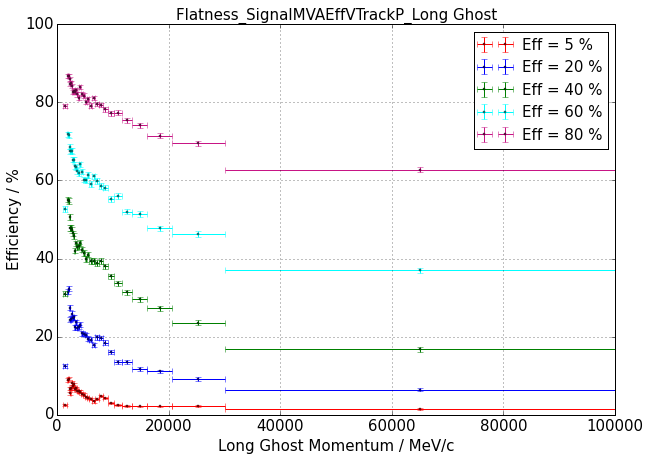

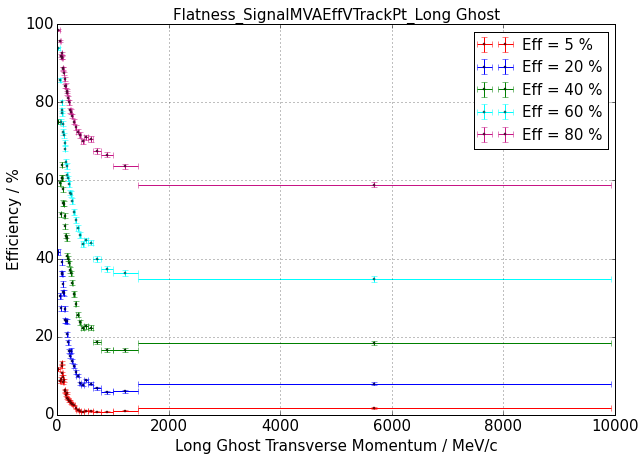

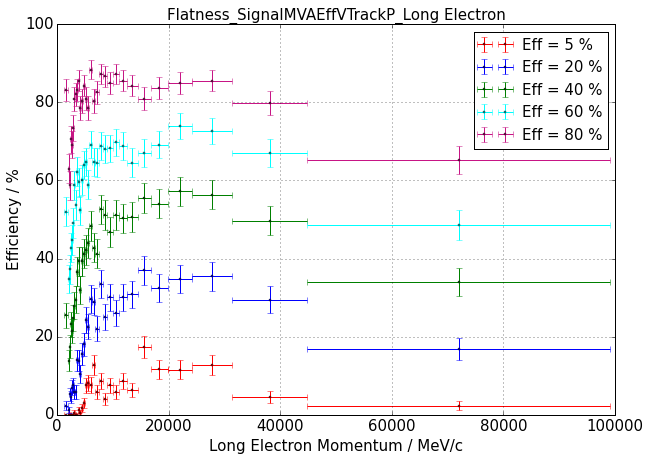

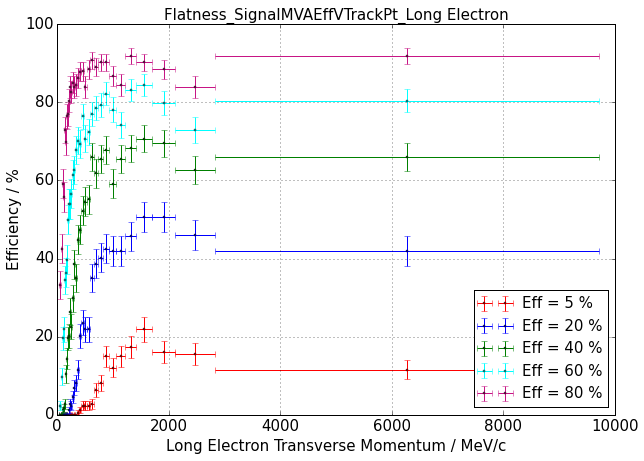

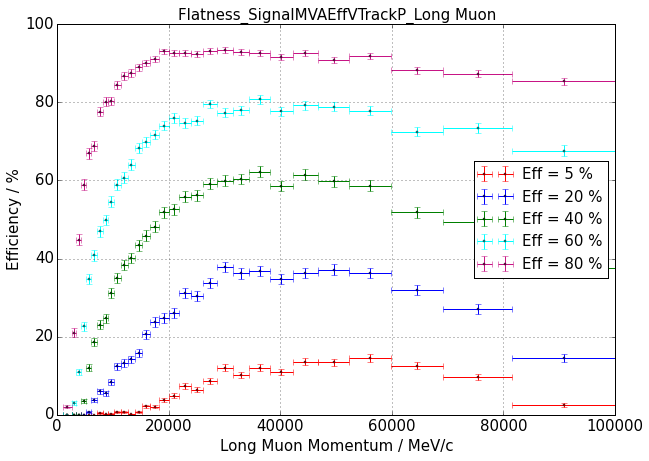

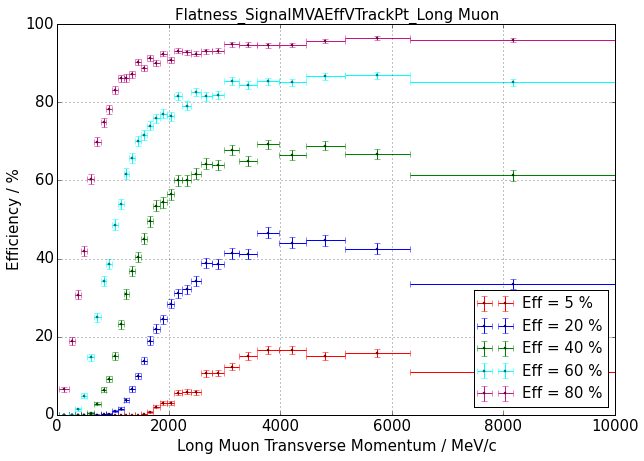

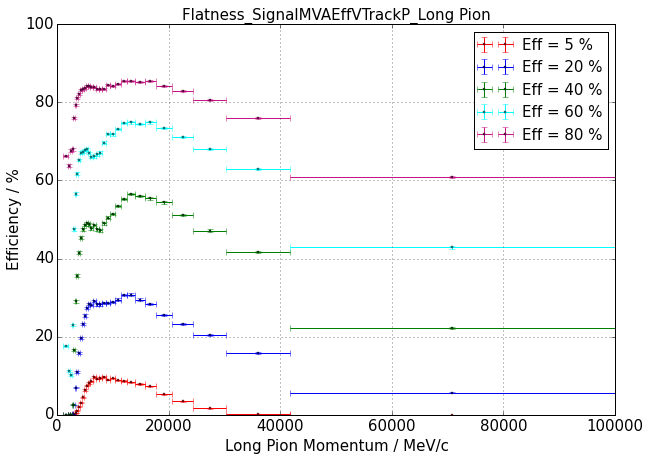

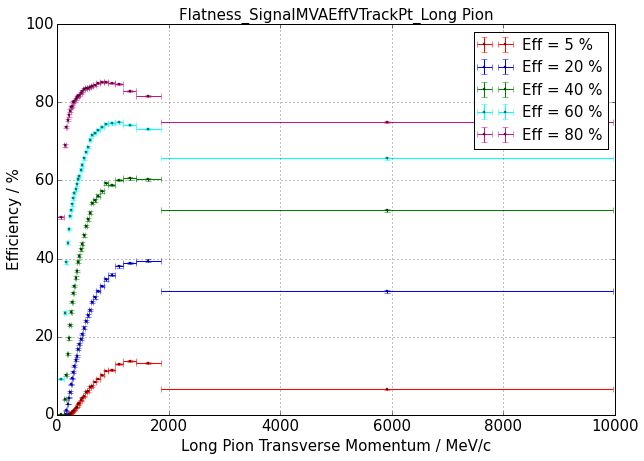

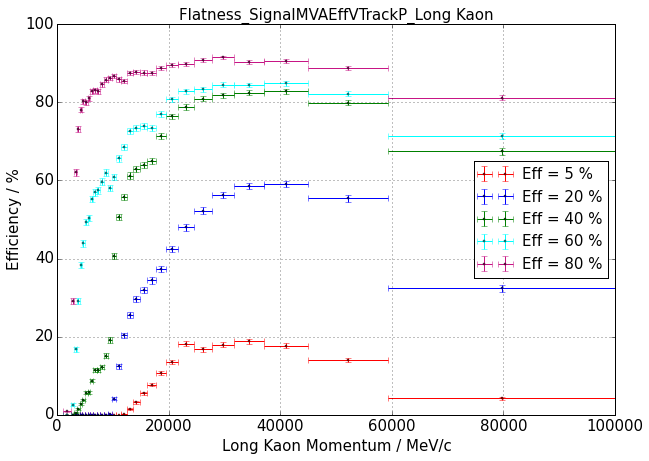

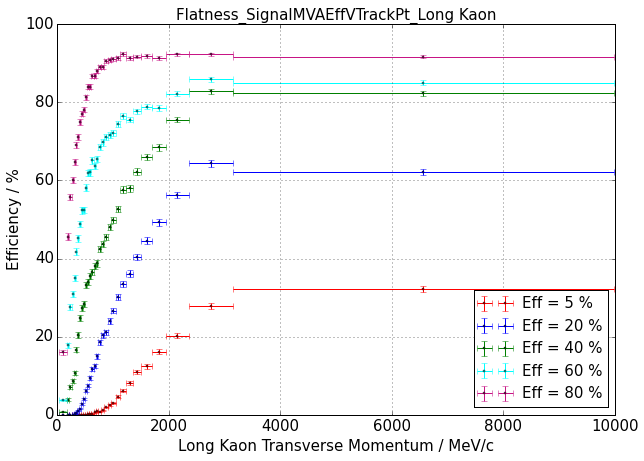

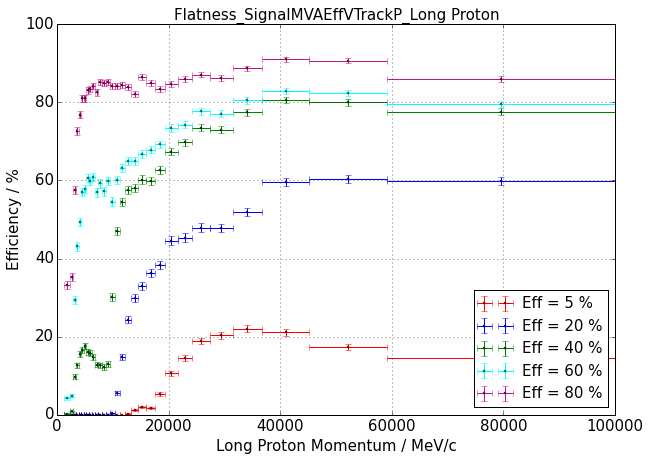

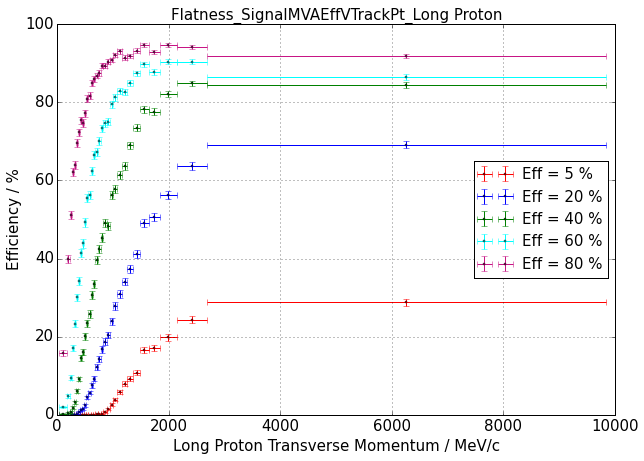

In [116]:
utils.get_all_flatness_figures(data_eval, proba_eval, labels_eval, 'Long', particles, save_path=new_work_path, show=True)